In [1]:
import itertools
import mysql.connector
from mysql.connector import errorcode
from secret import mySQL_password # Note: secret.py file

import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, chi2, fisher_exact
pd.options.display.float_format = '{:,}'.format
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
#plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [3]:
# Create or get a MySQL connection object
cnx = mysql.connector.connect(user='root', password=mySQL_password,
                              host='127.0.0.1',
                              database='trails')
print(cnx)

In [4]:
# Instantiates and returns a cursor using C Extension
cursor = cnx.cursor()

### Exploratory Data Analysis on `trail_info` table

In [5]:
def null_counts(col):

    sql = "SELECT COUNT(*) FROM trails.trail_info WHERE {} IS NULL".format(col)
    cursor.execute(sql)
    result = cursor.fetchall()

    for row in result:
        print(row[0])

In [6]:
sql = "SELECT COUNT(*) FROM trails.trail_info"
cursor.execute(sql)
result = cursor.fetchall()

for row in result:
    print(row[0])

10146


#### Trail ID

In [7]:
sql = "SELECT COUNT(DISTINCT trail_id) FROM trails.trail_info"
cursor.execute(sql)
result = cursor.fetchall()

for row in result:
    print(row[0])

10146


#### State

In [8]:
null_counts('state')

0


In [9]:
sql = """
SELECT state, COUNT(*)
FROM trails.trail_info
GROUP BY state
"""
cursor.execute(sql)
result = cursor.fetchall()

for row in result:
    print(row)

('California', 10137)
('', 7)
('Oregon', 1)
('United States of Amer', 1)


In [10]:
sql = """
SELECT * 
FROM trails.trail_info
WHERE state != 'California'
"""
cursor.execute(sql)
trail_info_list_not_CA_sql = [i[0:4] for i in cursor.fetchall()]

In [11]:
trail_info_list_not_CA_sql

[('', 'Santa Rosa', 'Creekside Trail to Big Leaf Trail Loop', 10018817),
 ('Oregon', 'Ashland', 'Pilot Rock Trail', 10027241),
 ('', 'Twentynine Palms', 'Wall Street Mill Trail', 10036072),
 ('', 'Tehachapi', 'TMTA Lehigh Trail Loop', 10302436),
 ('', 'Stonyford', 'Snow Mountain Wilderness Loop', 10309312),
 ('', 'Cedarpines Park', 'Camp Seely to Cedarpines Park Loop', 10309399),
 ('', 'Ojai', 'Ojai to Ventura Bike Path via Downtown Ojai', 10318649),
 ('', 'Sunnyvale', 'Baylands Bike Path Loop', 10318863),
 ('United States of Amer', 'Calexico', 'Pista el Alacrán', 10652811)]

In [12]:
values = tuple(i[3] for i in trail_info_list_not_CA_sql)

In [13]:
sql = """
SELECT url, trail_id
FROM trails.trail_urls_ca 
WHERE trail_id IN ({0})
""".format(', '.join(['%s'] * len(values)))
cursor.execute(sql, values)
trail_urls_list_not_CA_sql = [i[0:2] for i in cursor.fetchall()]

In [14]:
#trail_urls_list_not_CA_sql

Note: The trails above were confirmed to be in California after visiting websites except for trail_id IN (10027241, 10652811) which will be removed from the `trail_info` table.  Those confirmed will be set to 'California'.

In [15]:
# sql = """
# UPDATE trails.trail_info 
# SET state='California' 
# WHERE trail_id IN (10018817, 10036072, 10302436, 10309312, 10309399, 10318649, 10318863)
# """

#### City

In [16]:
null_counts('city')

3


In [17]:
sql = """
SELECT * 
FROM trails.trail_info
WHERE city IS NULL
"""
cursor.execute(sql)
trail_info_list_city_NULL_sql = [i[0:4] for i in cursor.fetchall()]

In [18]:
trail_info_list_city_NULL_sql

[('California', None, 'La Jolla Heights Preserve Walk', 10541176),
 ('California', None, 'Plantation Trail to Grand View Point', 10577579),
 ('California', None, 'Carrington Point Trail', 10581562)]

In [19]:
values = tuple(i[3] for i in trail_info_list_city_NULL_sql)

In [20]:
sql = """
SELECT url, trail_id, city
FROM trails.trail_urls_ca 
WHERE trail_id IN ({0})
""".format(', '.join(['%s'] * len(values)))
cursor.execute(sql, values)
trail_urls_list_city_NULL_sql = [i[0:3] for i in cursor.fetchall()]

In [21]:
#trail_urls_list_city_NULL_sql

#### Trail Name

In [22]:
null_counts('trail_name')

0


#### Trail Difficulty

In [23]:
null_counts('trail_difficulty')

0


In [24]:
sql = """
SELECT trail_difficulty, COUNT(*)
FROM trails.trail_info
GROUP BY trail_difficulty
"""
cursor.execute(sql)
result = cursor.fetchall()

for row in result:
    print(row)

('hard', 1928)
('easy', 3108)
('moderate', 5110)


#### Stars

In [25]:
null_counts('stars')

0


In [26]:
sql = """
SELECT stars, COUNT(*)
FROM trails.trail_info
GROUP BY stars
ORDER BY stars
"""
cursor.execute(sql)
result = cursor.fetchall()

for row in result:
    print(row)

(Decimal('0.0'), 102)
(Decimal('1.0'), 25)
(Decimal('1.5'), 10)
(Decimal('2.0'), 43)
(Decimal('2.5'), 74)
(Decimal('3.0'), 228)
(Decimal('3.5'), 655)
(Decimal('4.0'), 2744)
(Decimal('4.5'), 5582)
(Decimal('5.0'), 683)


#### Number of Reviews

In [27]:
null_counts('num_reviews')

0


#### Trail Region

In [28]:
null_counts('trail_region')

0


#### Distance

In [29]:
null_counts('distance')

0


#### Duration Mins

In [30]:
null_counts('duration_mins')

409


In [31]:
sql = """
SELECT trail_id, trail_name, duration_mins
FROM trails.trail_info
WHERE duration_mins IS NULL
"""
cursor.execute(sql)
trail_info_list_duration_mins_NULL_sql = [i[0:3] for i in cursor.fetchall()]

In [32]:
trail_info_list_duration_mins_NULL_sql[0:10]

[(10001403, 'High Point Truck Trail', None),
 (10005408, 'Main Divide Truck Trail to Santiago Peak [CLOSED]', None),
 (10006296, 'Bee Canyon Truck OHV Trail', None),
 (10006938, 'McIvers Road OHV Trail', None),
 (10007150, 'Pilot Rock OHV Trail', None),
 (10007329, 'Wildomar OHV Area [CLOSED]', None),
 (10007673, 'Soquel Demonstration Forest Flow Trail', None),
 (10010256, 'Rockhouse OHV Trail', None),
 (10012063, 'Old Spanish Trail Highway', None),
 (10013046, 'Mother Grundy Truck Trail', None)]

In [33]:
values = tuple(i[0] for i in trail_info_list_duration_mins_NULL_sql)

In [34]:
sql = """
SELECT url, trail_id, trail_name
FROM trails.trail_urls_ca 
WHERE trail_id IN ({0})
""".format(', '.join(['%s'] * len(values)))
cursor.execute(sql, values)
trail_urls_list_duration_mins_NULL_sql = [i[0:3] for i in cursor.fetchall()]

In [35]:
#trail_urls_list_duration_mins_NULL_sql[0:10]

Note: The trails above were confirmed to not have a duration minutes parameter.

#### Elevation Gain

In [36]:
null_counts('elevation_gain')

0


#### Route Type

In [37]:
null_counts('route_type')

0


In [38]:
sql = """
SELECT route_type, COUNT(*)
FROM trails.trail_info
GROUP BY route_type
"""
cursor.execute(sql)
result = cursor.fetchall()

for row in result:
    print(row)

('Out & Back', 4634)
('Loop', 4885)
('Point to Point', 627)


#### Trail Tags

In [39]:
null_counts('trail_tags_str')

0


### Retrieve the `trail_info` table from the database and create Pandas DataFrame

In [40]:
# Read SQL query or database table into a DataFrame
state_trails_df = pd.read_sql('SELECT * FROM trails.trail_info', con=cnx)
state_trails_df.head()

,state,city,trail_name,trail_id,trail_difficulty,stars,num_reviews,trail_region,distance,duration_mins,elevation_gain,route_type,trail_tags_str
0,California,Angelus Oaks,Forsee Creek Trail,10000006,hard,4.5,116,San Bernardino National Forest,21.9 km,449.0,"1,331 m",Out & Back,DogFriendly Backpacking Camping Hiking Forest ...
1,California,Pescadero,Franklin Point Trail [CLOSED],10000015,easy,4.5,25,Año Nuevo State Park,1.1 km,19.0,16 m,Out & Back,KidFriendly Hiking Walking BirdWatching Beach ...
2,California,Thousand Palms,Indian Palms Trail,10000044,easy,4.0,20,Coachella Valley Preserve,1.9 km,33.0,34 m,Out & Back,KidFriendly Hiking NatureTrips Walking Views W...
3,California,Sierraville,Mount Lola Trail,10000118,hard,4.5,82,Tahoe National Forest,17.5 km,366.0,772 m,Out & Back,DogFriendly Backpacking Hiking HorsebackRiding...
4,California,Santa Rosa,Cobblestone Trail Loop,10000133,moderate,4.5,103,Trione-Annadel State Park,7.9 km,141.0,173 m,Loop,Hiking MountainBiking NatureTrips Running Lake...


### Examine the DataFrame

In [41]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(state_trails_df.shape[0], state_trails_df.shape[1]))

Rows: 10146, Cols: 13


In [42]:
# Print a concise summary of a DataFrame including the index dtype and column dtypes, non-null values, and memory usage
# Note: Useful to quickly see if null values exist 
state_trails_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10146 entries, 0 to 10145
Data columns (total 13 columns):
state               10146 non-null object
city                10143 non-null object
trail_name          10146 non-null object
trail_id            10146 non-null int64
trail_difficulty    10146 non-null object
stars               10146 non-null float64
num_reviews         10146 non-null int64
trail_region        10146 non-null object
distance            10146 non-null object
duration_mins       9737 non-null float64
elevation_gain      10146 non-null object
route_type          10146 non-null object
trail_tags_str      10146 non-null object
dtypes: float64(2), int64(2), object(9)
memory usage: 1.0+ MB


In [43]:
# Column names (which is "an index")
state_trails_df.columns

Index(['state', 'city', 'trail_name', 'trail_id', 'trail_difficulty', 'stars',
       'num_reviews', 'trail_region', 'distance', 'duration_mins',
       'elevation_gain', 'route_type', 'trail_tags_str'],
      dtype='object')

In [44]:
# Sort a DataFrame by multiple columns
# Note: ascending: sort ascending vs. descending; ascending=True is default
#       inplace=True changes the original DataFrame
# state_trails_df.sort_values(by=['X', 'Y'], ascending=True, inplace=True)

In [45]:
# Print the first 5 rows and the last 5 rows of the DataFrame
state_trails_df.head().append(state_trails_df.tail())

,state,city,trail_name,trail_id,trail_difficulty,stars,num_reviews,trail_region,distance,duration_mins,elevation_gain,route_type,trail_tags_str
0,California,Angelus Oaks,Forsee Creek Trail,10000006,hard,4.5,116,San Bernardino National Forest,21.9 km,449.0,"1,331 m",Out & Back,DogFriendly Backpacking Camping Hiking Forest ...
1,California,Pescadero,Franklin Point Trail [CLOSED],10000015,easy,4.5,25,Año Nuevo State Park,1.1 km,19.0,16 m,Out & Back,KidFriendly Hiking Walking BirdWatching Beach ...
2,California,Thousand Palms,Indian Palms Trail,10000044,easy,4.0,20,Coachella Valley Preserve,1.9 km,33.0,34 m,Out & Back,KidFriendly Hiking NatureTrips Walking Views W...
3,California,Sierraville,Mount Lola Trail,10000118,hard,4.5,82,Tahoe National Forest,17.5 km,366.0,772 m,Out & Back,DogFriendly Backpacking Hiking HorsebackRiding...
4,California,Santa Rosa,Cobblestone Trail Loop,10000133,moderate,4.5,103,Trione-Annadel State Park,7.9 km,141.0,173 m,Loop,Hiking MountainBiking NatureTrips Running Lake...
10141,California,Fremont,Bayview and Meadowlark (Accessible),10740073,moderate,4.5,46,Coyote Hills Regional Park,2.4 mi,59.0,118 ft,Loop,DogFriendly WheelchairFriendly KidFriendly Str...
10142,California,Idyllwild-Pine Cove,Deer Springs Trail to Round Valley,10740648,hard,4.5,8,Mount San Jacinto State Park,16.0 mi,565.0,"4,819 ft",Out & Back,Backpacking Camping Hiking NatureTrips Forest ...
10143,California,Big Pine,Birch Lake,10740792,hard,0.0,0,Inyo National Forest,13.0 mi,495.0,"5,055 ft",Out & Back,Backpacking Camping Hiking NatureTrips Lake Vi...
10144,California,Lee Vining,Bloody Canyon Trail to Silver Lake via Rush Cr...,10741536,hard,0.0,0,Ansel Adams Wilderness,21.8 mi,706.0,"5,285 ft",Point to Point,Backpacking Camping Hiking NatureTrips BirdWat...
10145,California,Sausalito,South Rodeo Beach,10741577,easy,4.5,53,Marin Headlands,0.6 mi,13.0,108 ft,Out & Back,KidFriendly Fishing Hiking NatureTrips BirdWat...


### Examine Missing Values

In [46]:
# Count the missing values in each column of a DataFrame - sum() works because True is 1 and False is 0
null_counts = state_trails_df.isnull().sum()
null_counts[null_counts > 0]

city               3
duration_mins    409
dtype: int64

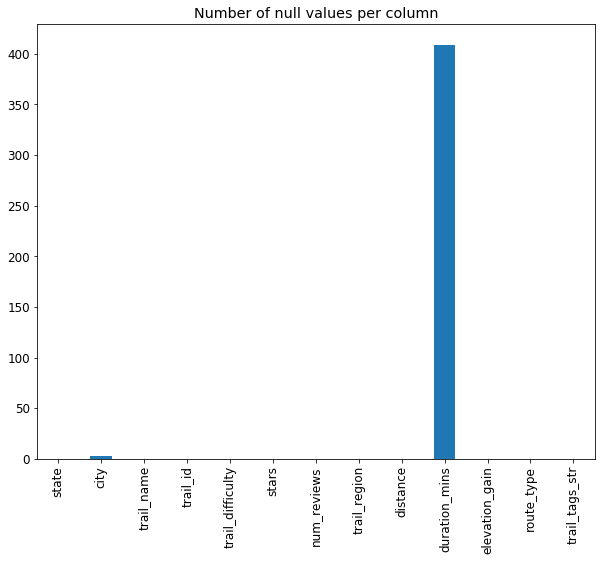

In [47]:
# Create a vertical bar plot by number of missing values per column using matplotlib
# Note: figsize: a tuple (width, height) in inches
state_trails_df.isnull().sum().plot.bar(figsize=(10, 8));
plt.title('Number of null values per column');

### Examine the Columns

In [48]:
state_trails_df['state'].value_counts(dropna=False)

California               10137
                             7
Oregon                       1
United States of Amer        1
Name: state, dtype: int64

In [49]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
def value_counts(df, var, bar):
    value_counts = df[var].value_counts(dropna=False)
    df_ = value_counts.rename_axis(var).reset_index(name='counts')
    df_['percent'] = round(df_.counts / sum(df_.counts), 3)
    
    if bar:
        # Create a vertical bar plot
        # Note: figsize: a tuple (width, height) in inches
        #       rot: rotation for ticks (xticks for vertical, yticks for horizontal plots)
        ax = df[var].value_counts(normalize=True, dropna=False).plot(kind='bar', figsize=(10, 6), rot=0);
        ax.set_ylabel('Percent');
    
    return df_

#### State

,state,counts,percent
0,California,10137,0.999
1,,7,0.001
2,Oregon,1,0.0
3,United States of Amer,1,0.0


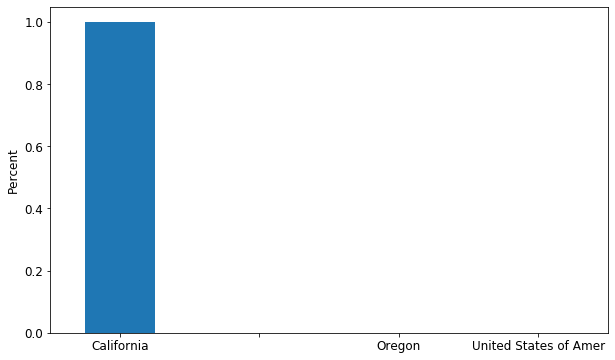

In [50]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts(state_trails_df, 'state', bar=True)

In [51]:
state_trails_df[state_trails_df.state != 'California']

,state,city,trail_name,trail_id,trail_difficulty,stars,num_reviews,trail_region,distance,duration_mins,elevation_gain,route_type,trail_tags_str
761,,Santa Rosa,Creekside Trail to Big Leaf Trail Loop,10018817,moderate,4.5,220,Shiloh Ranch Regional Park,3.8 mi,117.0,616 ft,Loop,KidFriendly Hiking NatureTrips Walking BirdWat...
1203,Oregon,Ashland,Pilot Rock Trail,10027241,hard,4.5,187,Soda Mountain Wilderness,2.8 mi,101.0,810 ft,Out & Back,DogsOnLeash Hiking NatureTrips RockClimbing Bi...
2234,,Twentynine Palms,Wall Street Mill Trail,10036072,easy,4.0,196,Joshua Tree National Park,2.4 mi,62.0,88 ft,Out & Back,KidFriendly Hiking NatureTrips Walking BirdWat...
6207,,Tehachapi,TMTA Lehigh Trail Loop,10302436,moderate,4.5,28,"Tehachapi, California",10.7 mi,310.0,"1,272 ft",Loop,DogsOnLeash KidFriendly Hiking MountainBiking ...
6572,,Stonyford,Snow Mountain Wilderness Loop,10309312,hard,4.5,7,Snow Mountain Wilderness,38.6 mi,"1,261.0","8,090 ft",Loop,Backpacking Camping Fishing Hiking NatureTrips...
6574,,Cedarpines Park,Camp Seely to Cedarpines Park Loop,10309399,moderate,4.0,17,San Bernardino National Forest,2.8 mi,68.0,849 ft,Loop,Hiking NatureTrips Walking BirdWatching Forest...
6932,,Ojai,Ojai to Ventura Bike Path via Downtown Ojai,10318649,moderate,4.5,58,"Ojai, California",14.9 mi,365.0,134 ft,Point to Point,DogsOnLeash KidFriendly Hiking RoadBiking Runn...
6939,,Sunnyvale,Baylands Bike Path Loop,10318863,easy,4.5,75,Sunnyvale Baylands Park,1.2 mi,29.0,6 ft,Loop,KidFriendly NatureTrips Walking BirdWatching R...
9893,United States of Amer,Calexico,Pista el Alacrán,10652811,easy,4.5,8,"Calexico, California",2.8 mi,nan,164 ft,Loop,MountainBiking


#### Drop non-California observations

In [52]:
# Return elements, either from `x` or `y`, depending on `condition`
state_trails_df['non_california'] = np.where(state_trails_df.state.isin(['California', '']), 0, 1)

In [53]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
state_trails_df.non_california.value_counts(dropna=False)

0    10144
1        2
Name: non_california, dtype: int64

In [54]:
# Excluding non-california values
state_trails_df = state_trails_df[state_trails_df.non_california == 0]

# Remove columns by specifying directly column names
# Note: inplace=True changes the original DataFrame
state_trails_df.drop(columns=['non_california'], inplace=True)

#### Assign `state` to 'California' for the following `trail_id`s that were confirmed to be California trails

In [55]:
state_trails_df['trail_id'][state_trails_df.state != 'California']

761     10018817
2234    10036072
6207    10302436
6572    10309312
6574    10309399
6932    10318649
6939    10318863
Name: trail_id, dtype: int64

In [56]:
values = state_trails_df['trail_id'][state_trails_df.state != 'California'].values.tolist()
values

[10018817, 10036072, 10302436, 10309312, 10309399, 10318649, 10318863]

In [57]:
# Return elements, either from `x` or `y`, depending on `condition`
state_trails_df['state'] = np.where(state_trails_df.trail_id.isin(values), 'California', state_trails_df.state)

In [58]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
state_trails_df.state.value_counts(dropna=False)

California    10144
Name: state, dtype: int64

In [59]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(state_trails_df.shape[0], state_trails_df.shape[1]))

Rows: 10144, Cols: 13


#### City

In [60]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts(state_trails_df, 'city', bar=False)

,city,counts,percent
0,Yosemite Valley,213,0.021
1,Los Angeles,134,0.013
2,San Diego,131,0.013
3,Oakland,125,0.012
4,Mill Valley,110,0.011
...,...,...,...
844,Goodyears Bar,1,0.0
845,Ione,1,0.0
846,Daggett,1,0.0
847,Mather,1,0.0


In [61]:
# Detect missing values
state_trails_df[state_trails_df.city.isnull()]

,state,city,trail_name,trail_id,trail_difficulty,stars,num_reviews,trail_region,distance,duration_mins,elevation_gain,route_type,trail_tags_str
9040,California,None,La Jolla Heights Preserve Walk,10541176,moderate,4.5,48,La Jolla Natural Park,1.2 mi,43.0,344 ft,Out & Back,Hiking NatureTrips Walking Views WildFlowers
9314,California,None,Plantation Trail to Grand View Point,10577579,moderate,4.5,8,San Bernardino National Forest,7.7 mi,227.0,"1,010 ft",Out & Back,Hiking Running Forest Views Wildlife
9372,California,None,Carrington Point Trail,10581562,moderate,4.5,2,Channel Islands National Park,8.8 mi,253.0,987 ft,Out & Back,Hiking NatureTrips BirdWatching Running Beach ...


In [62]:
# Note: The city names were found for the following trails after searching the internet for the trail name
state_trails_df['city'] = np.where(state_trails_df.trail_id == 10541176, 'La Jolla', state_trails_df.city)
state_trails_df['city'] = np.where(state_trails_df.trail_id == 10577579, 'Big Bear Lake', state_trails_df.city)

#### Trail Difficulty

In [63]:
# Map values of Series using input correspondence (i.e., map existing input values to new outputs values)
state_trails_df['trail_difficulty'] = state_trails_df.trail_difficulty.map({'easy':'Easy', 'moderate':'Moderate', 'hard':'Hard'})
state_trails_df['trail_difficulty_ord'] = state_trails_df.trail_difficulty.map({'Easy':0, 'Moderate':1, 'Hard':2})

In [64]:
# Compute a frequency table of two factors
# Builtin-Styles - https://pandas.pydata.org/pandas-docs/stable/style.html
orange = sns.light_palette('orange', as_cmap=True)
pd.crosstab(state_trails_df.trail_difficulty.fillna(' NaN'), state_trails_df.trail_difficulty_ord.fillna(' NaN'), margins=True, margins_name='Total', dropna=False).style.background_gradient(cmap=orange)

trail_difficulty_ord,0,1,2,Total
trail_difficulty,,,,
Easy,3107,0,0,3107
Hard,0,0,1927,1927
Moderate,0,5110,0,5110
Total,3107,5110,1927,10144


,trail_difficulty,counts,percent
0,Moderate,5110,0.504
1,Easy,3107,0.306
2,Hard,1927,0.19


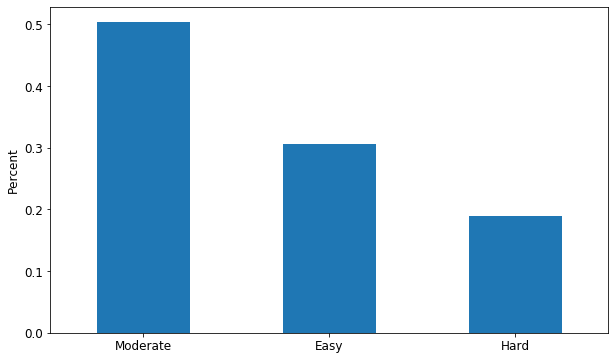

In [65]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts(state_trails_df, 'trail_difficulty', bar=True)

#### Stars

,stars,counts,percent
0,4.5,5580,0.55
1,4.0,2744,0.271
2,5.0,683,0.067
3,3.5,655,0.065
4,3.0,228,0.022
5,0.0,102,0.01
6,2.5,74,0.007
7,2.0,43,0.004
8,1.0,25,0.002
9,1.5,10,0.001


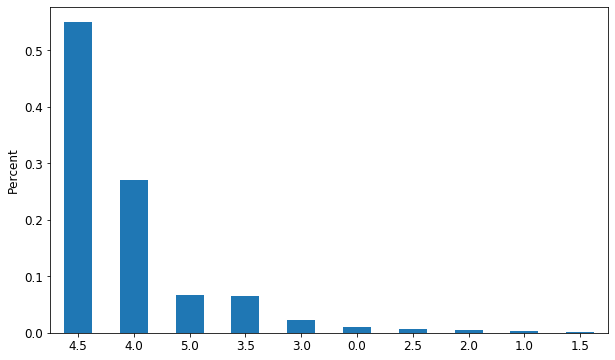

In [66]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts(state_trails_df, 'stars', bar=True)

#### Number of Reviews

In [67]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts(state_trails_df, 'num_reviews', bar=False)

,num_reviews,counts,percent
0,5,252,0.025
1,3,240,0.024
2,1,239,0.024
3,2,237,0.023
4,6,228,0.022
...,...,...,...
724,923,1,0.0
725,1051,1,0.0
726,1083,1,0.0
727,1163,1,0.0


#### Region

In [68]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts(state_trails_df, 'trail_region', bar=False)

,trail_region,counts,percent
0,Angeles National Forest,255,0.025
1,Yosemite National Park,254,0.025
2,Tahoe National Forest,201,0.02
3,San Bernardino National Forest,198,0.02
4,Los Padres National Forest,195,0.019
...,...,...,...
1890,Freedom Park,1,0.0
1891,"Santa Maria, California",1,0.0
1892,Garcia Wilderness,1,0.0
1893,Fullerton Arboretum,1,0.0


#### Distance 

In [69]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts(state_trails_df, 'distance', bar=False)

,distance,counts,percent
0,2.8 mi,145,0.014
1,3.3 mi,130,0.013
2,4.1 mi,129,0.013
3,2.5 mi,127,0.013
4,2.1 mi,125,0.012
...,...,...,...
497,46.0 mi,1,0.0
498,63.3 mi,1,0.0
499,77.8 mi,1,0.0
500,76.9 mi,1,0.0


Note: Distance in kilometers is contained in the data.

In [70]:
# Distance containing 'mi' for miles
state_trails_df[state_trails_df['distance'].str.contains('mi')].shape[0]

10120

In [71]:
# Distance containing 'km' for kilometers
state_trails_df[state_trails_df['distance'].str.contains('km')].shape[0]

24

In [72]:
state_trails_df[['trail_id', 'distance']][state_trails_df['distance'].str.contains('km')].head()

,trail_id,distance
0,10000006,21.9 km
1,10000015,1.1 km
2,10000044,1.9 km
3,10000118,17.5 km
4,10000133,7.9 km


In [73]:
# Return elements, either from `x` or `y`, depending on `condition`
state_trails_df['distance_km_flag'] = np.where(state_trails_df['distance'].str.contains('km'), 1, 0)

In [74]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
state_trails_df.distance_km_flag.value_counts(dropna=False)

0    10120
1       24
Name: distance_km_flag, dtype: int64

#### Converting `distance` to numeric measurement as `distance_numeric`

In [75]:
state_trails_df['distance_numeric'] = state_trails_df.distance.str.replace(',', '').str.extract('(\d*\.\d+|\d+)', expand=False).astype(float)

#### Converting `distance_numeric` to numeric measurement as `distance_miles`
Note: Records flagged as distance in kilometers will be converted to miles.

In [76]:
# Return elements, either from `x` or `y`, depending on `condition`
# Kilometer to mile conversion factor
conv_fac = 0.621371
state_trails_df['distance_miles'] = np.where(state_trails_df.distance_km_flag == 1, round(state_trails_df.distance_numeric * conv_fac, 1), state_trails_df.distance_numeric)

# Remove columns by specifying directly column names
# Note: inplace=True changes the original DataFrame
state_trails_df.drop(columns=['distance', 'distance_km_flag', 'distance_numeric'], inplace=True)

In [77]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts(state_trails_df, 'distance_miles', bar=False)

,distance_miles,counts,percent
0,2.8,145,0.014
1,3.3,130,0.013
2,4.1,129,0.013
3,2.5,129,0.013
4,2.1,125,0.012
...,...,...,...
475,33.5,1,0.0
476,64.5,1,0.0
477,35.2,1,0.0
478,48.5,1,0.0


#### Elevation Gain

In [78]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts(state_trails_df, 'elevation_gain', bar=False)

,elevation_gain,counts,percent
0,26 ft,48,0.005
1,13 ft,48,0.005
2,6 ft,48,0.005
3,16 ft,44,0.004
4,9 ft,44,0.004
...,...,...,...
1742,"68,221 ft",1,0.0
1743,"6,105 ft",1,0.0
1744,"4,603 ft",1,0.0
1745,"7,723 ft",1,0.0


Note: Elevation Gain in meters is contained in the data.

In [79]:
# Elevation gain containing 'ft' for feet
state_trails_df[state_trails_df['elevation_gain'].str.contains('ft')].shape[0]

10120

In [80]:
# Elevation gain containing 'm' for meters
state_trails_df[state_trails_df['elevation_gain'].str.contains('m')].shape[0]

24

In [81]:
state_trails_df[['trail_id', 'elevation_gain']][state_trails_df['elevation_gain'].str.contains('m')].head()

,trail_id,elevation_gain
0,10000006,"1,331 m"
1,10000015,16 m
2,10000044,34 m
3,10000118,772 m
4,10000133,173 m


In [82]:
# Return elements, either from `x` or `y`, depending on `condition`
state_trails_df['elevation_gain_m_flag'] = np.where(state_trails_df['elevation_gain'].str.contains('m'), 1, 0)

In [83]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
state_trails_df.elevation_gain_m_flag.value_counts(dropna=False)

0    10120
1       24
Name: elevation_gain_m_flag, dtype: int64

#### Converting `elevation_gain` to numeric measurement as `elevation_gain_numeric`

In [84]:
state_trails_df['elevation_gain_numeric'] = state_trails_df.elevation_gain.str.replace(',', '').str.extract('(\d*\.\d+|\d+)', expand=False).astype(int)

#### Converting `elevation_gain_numeric` to numeric measurement as `elevation_gain_ft`
Note: Records flagged as elevation gain in meters will be converted to feet.

In [85]:
# Return elements, either from `x` or `y`, depending on `condition`
# Meter to feet conversion factor
conv_fac = 0.3048
state_trails_df['elevation_gain_ft'] = np.where(state_trails_df.elevation_gain_m_flag == 1, round(state_trails_df.elevation_gain_numeric / conv_fac).astype(int), state_trails_df.elevation_gain_numeric)

# Remove columns by specifying directly column names
# Note: inplace=True changes the original DataFrame
state_trails_df.drop(columns=['elevation_gain', 'elevation_gain_m_flag', 'elevation_gain_numeric'], inplace=True)

In [86]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts(state_trails_df, 'elevation_gain_ft', bar=False)

,elevation_gain_ft,counts,percent
0,26,48,0.005
1,13,48,0.005
2,6,48,0.005
3,3,44,0.004
4,16,44,0.004
...,...,...,...
1731,8057,1,0.0
1732,13136,1,0.0
1733,8041,1,0.0
1734,10062,1,0.0


#### Duration Minutes

In [87]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts(state_trails_df, 'duration_mins', bar=False)

,duration_mins,counts,percent
0,nan,408,0.04
1,88.0,54,0.005
2,93.0,53,0.005
3,68.0,52,0.005
4,75.0,52,0.005
...,...,...,...
996,547.0,1,0.0
997,"2,529.0",1,0.0
998,562.0,1,0.0
999,"1,005.0",1,0.0


#### Route Type

,route_type,counts,percent
0,Loop,4884,0.481
1,Out & Back,4633,0.457
2,Point to Point,627,0.062


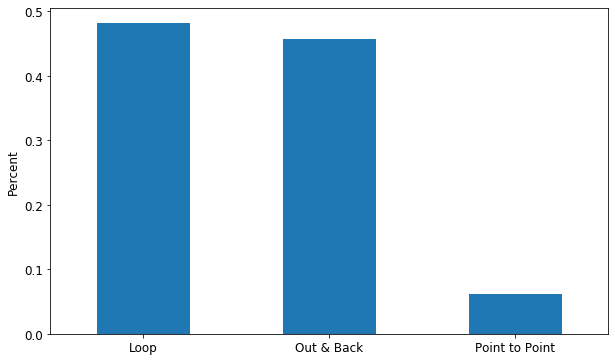

In [88]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts(state_trails_df, 'route_type', bar=True)

#### Trail Tags

In [89]:
state_trails_df['trail_tags_str_lst'] = state_trails_df.trail_tags_str.str.split(' ')
state_trails_df.head()

,state,city,trail_name,trail_id,trail_difficulty,stars,num_reviews,trail_region,duration_mins,route_type,trail_tags_str,trail_difficulty_ord,distance_miles,elevation_gain_ft,trail_tags_str_lst
0,California,Angelus Oaks,Forsee Creek Trail,10000006,Hard,4.5,116,San Bernardino National Forest,449.0,Out & Back,DogFriendly Backpacking Camping Hiking Forest ...,2,13.6,4367,"[DogFriendly, Backpacking, Camping, Hiking, Fo..."
1,California,Pescadero,Franklin Point Trail [CLOSED],10000015,Easy,4.5,25,Año Nuevo State Park,19.0,Out & Back,KidFriendly Hiking Walking BirdWatching Beach ...,0,0.7,52,"[KidFriendly, Hiking, Walking, BirdWatching, B..."
2,California,Thousand Palms,Indian Palms Trail,10000044,Easy,4.0,20,Coachella Valley Preserve,33.0,Out & Back,KidFriendly Hiking NatureTrips Walking Views W...,0,1.2,112,"[KidFriendly, Hiking, NatureTrips, Walking, Vi..."
3,California,Sierraville,Mount Lola Trail,10000118,Hard,4.5,82,Tahoe National Forest,366.0,Out & Back,DogFriendly Backpacking Hiking HorsebackRiding...,2,10.9,2533,"[DogFriendly, Backpacking, Hiking, HorsebackRi..."
4,California,Santa Rosa,Cobblestone Trail Loop,10000133,Moderate,4.5,103,Trione-Annadel State Park,141.0,Loop,Hiking MountainBiking NatureTrips Running Lake...,1,4.9,568,"[Hiking, MountainBiking, NatureTrips, Running,..."


In [90]:
# Identifying unique trail tags
unique_tags = set(itertools.chain.from_iterable(state_trails_df.trail_tags_str_lst))
#unique_tags = state_trails_df.trail_tags_str_lst.explode().unique()
unique_tags

{'Backpacking',
 'Beach',
 'BikeTouring',
 'BirdWatching',
 'Blowdown',
 'BridgeOut',
 'Bugs',
 'Camping',
 'Cave',
 'CityWalk',
 'Closed',
 'CrossCountrySkiing',
 'DogFriendly',
 'DogsOnLeash',
 'Event',
 'Fee',
 'Fishing',
 'Forest',
 'Hiking',
 'HistoricSite',
 'HorsebackRiding',
 'HotSprings',
 'KidFriendly',
 'Lake',
 'MountainBiking',
 'Muddy',
 'NatureTrips',
 'NoDogs',
 'NoShade',
 'OffTrail',
 'Ohv/OffRoadDriving',
 'OverGrown',
 'PaddleSports',
 'PartiallyPaved',
 'Paved',
 'PrivateProperty',
 'PubWalk',
 'RailsTrails',
 'River',
 'RoadBiking',
 'RockClimbing',
 'Rocky',
 'Running',
 'ScenicDriving',
 'Scramble',
 'Skiing',
 'Snow',
 'Snowshoeing',
 'StrollerFriendly',
 'Views',
 'Walking',
 'WashedOut',
 'Waterfall',
 'WheelchairFriendly',
 'WildFlowers',
 'Wildlife'}

In [91]:
# Creating trail tag flags
tag_flags = state_trails_df['trail_tags_str_lst'].str.join(sep='*').str.get_dummies(sep='*')
tag_flags.head()

,Backpacking,Beach,BikeTouring,BirdWatching,Blowdown,BridgeOut,Bugs,Camping,Cave,CityWalk,...,Snow,Snowshoeing,StrollerFriendly,Views,Walking,WashedOut,Waterfall,WheelchairFriendly,WildFlowers,Wildlife
0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,1
1,0,1,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [92]:
# Concatenate pandas objects along a particular axis with optional set logic along the other axes
# Note: axis: the axis to concatenate along; {0/'index', 1/'columns'}, default 0
state_trails_df = pd.concat([state_trails_df, tag_flags], axis=1)
state_trails_df.head()

,state,city,trail_name,trail_id,trail_difficulty,stars,num_reviews,trail_region,duration_mins,route_type,...,Snow,Snowshoeing,StrollerFriendly,Views,Walking,WashedOut,Waterfall,WheelchairFriendly,WildFlowers,Wildlife
0,California,Angelus Oaks,Forsee Creek Trail,10000006,Hard,4.5,116,San Bernardino National Forest,449.0,Out & Back,...,0,0,0,1,0,0,0,0,1,1
1,California,Pescadero,Franklin Point Trail [CLOSED],10000015,Easy,4.5,25,Año Nuevo State Park,19.0,Out & Back,...,0,0,0,1,1,0,0,0,1,1
2,California,Thousand Palms,Indian Palms Trail,10000044,Easy,4.0,20,Coachella Valley Preserve,33.0,Out & Back,...,0,0,0,1,1,0,0,0,1,1
3,California,Sierraville,Mount Lola Trail,10000118,Hard,4.5,82,Tahoe National Forest,366.0,Out & Back,...,0,0,0,1,0,0,0,0,1,1
4,California,Santa Rosa,Cobblestone Trail Loop,10000133,Moderate,4.5,103,Trione-Annadel State Park,141.0,Loop,...,0,0,0,1,0,0,0,0,0,0


In [93]:
# Remove columns by specifying directly column names
# Note: inplace=True changes the original DataFrame
state_trails_df.drop(columns=['trail_tags_str', 'trail_tags_str_lst'], inplace=True)

In [94]:
# Print a concise summary of a DataFrame including the index dtype and column dtypes, non-null values, and memory usage
# Note: Useful to quickly see if null values exist 
state_trails_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10144 entries, 0 to 10145
Data columns (total 69 columns):
state                   10144 non-null object
city                    10143 non-null object
trail_name              10144 non-null object
trail_id                10144 non-null int64
trail_difficulty        10144 non-null object
stars                   10144 non-null float64
num_reviews             10144 non-null int64
trail_region            10144 non-null object
duration_mins           9736 non-null float64
route_type              10144 non-null object
trail_difficulty_ord    10144 non-null int64
distance_miles          10144 non-null float64
elevation_gain_ft       10144 non-null int64
Backpacking             10144 non-null int64
Beach                   10144 non-null int64
BikeTouring             10144 non-null int64
BirdWatching            10144 non-null int64
Blowdown                10144 non-null int64
BridgeOut               10144 non-null int64
Bugs                    1

### Summarize the DataFrame

In [95]:
# Describe numeric columns
# Generates descriptive summary statistics of the central tendency, dispersion, and shape of the distribution
# Note: By default only numeric (int64) fields are returned
#       Excludes "NaN" (missing) values
round(state_trails_df[['trail_id', 'stars', 'num_reviews', 'duration_mins', 'elevation_gain_ft', 'distance_miles']].describe(), 3)

,trail_id,stars,num_reviews,duration_mins,elevation_gain_ft,distance_miles
count,"10,144.0","10,144.0","10,144.0","9,736.0","10,144.0","10,144.0"
mean,"10,264,364.52",4.218,96.336,240.325,"1,514.581",8.142
std,"184,246.512",0.647,205.405,885.314,"4,814.886",28.717
min,"10,000,006.0",0.0,0.0,2.0,0.0,0.1
25%,"10,039,832.5",4.0,12.0,80.0,341.0,2.7
50%,"10,273,475.5",4.5,36.0,152.0,862.0,5.1
75%,"10,350,852.0",4.5,97.0,281.0,"1,791.75",9.3
max,"10,741,577.0",5.0,"5,135.0","81,440.0","429,832.0","2,650.0"


#### Greater than 95th percentile of `elevation_gain_ft`

In [96]:
p_95 = state_trails_df.elevation_gain_ft.quantile(0.95)
above_p_95 = state_trails_df[['trail_id', 'trail_difficulty', 'duration_mins', 'elevation_gain_ft', 'distance_miles']][state_trails_df.elevation_gain_ft.gt(p_95)].sort_values(by=['elevation_gain_ft'], ascending=True)
print(len(above_p_95))
above_p_95

507


,trail_id,trail_difficulty,duration_mins,elevation_gain_ft,distance_miles
2249,10036219,Hard,854.0,4803,27.3
8744,10463428,Moderate,nan,4803,24.1
8817,10480470,Hard,680.0,4803,20.1
9033,10541113,Hard,497.0,4806,12.5
4086,10260190,Hard,811.0,4809,25.5
...,...,...,...,...,...
8491,10414459,Hard,"7,249.0",43057,227.8
8490,10414374,Hard,"7,565.0",45246,237.2
190,10004781,Hard,"6,774.0",46030,203.1
4879,10271383,Hard,"9,855.0",68221,293.4


What is the distribution of `trail_difficulty` for trails with `elevation_gain` > 95th percentile?

,trail_difficulty,counts,percent
0,Hard,405,0.799
1,Moderate,88,0.174
2,Easy,14,0.028


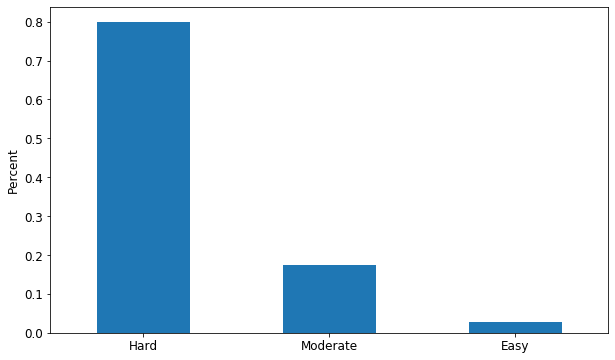

In [97]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts(above_p_95, 'trail_difficulty', bar=True)

#### Greater than 99th percentile of `elevation_gain_ft`

In [98]:
p_99 = state_trails_df.elevation_gain_ft.quantile(0.99)
above_p_99 = state_trails_df[['trail_id', 'trail_difficulty', 'duration_mins', 'elevation_gain_ft', 'distance_miles']][state_trails_df.elevation_gain_ft.gt(p_99)].sort_values(by=['elevation_gain_ft'], ascending=True)
print(len(above_p_99))
above_p_99

102


,trail_id,trail_difficulty,duration_mins,elevation_gain_ft,distance_miles
7084,10323769,Hard,"1,112.0",9419,30.2
9741,10611496,Hard,nan,9452,46.2
1705,10031436,Hard,"1,478.0",9458,53.3
7513,10346286,Hard,"1,604.0",9478,50.5
7358,10339460,Hard,"1,916.0",9550,63.3
...,...,...,...,...,...
8491,10414459,Hard,"7,249.0",43057,227.8
8490,10414374,Hard,"7,565.0",45246,237.2
190,10004781,Hard,"6,774.0",46030,203.1
4879,10271383,Hard,"9,855.0",68221,293.4


What is the distribution of `trail_difficulty` for trails with `elevation_gain` > 99th percentile?

,trail_difficulty,counts,percent
0,Hard,83,0.814
1,Moderate,17,0.167
2,Easy,2,0.02


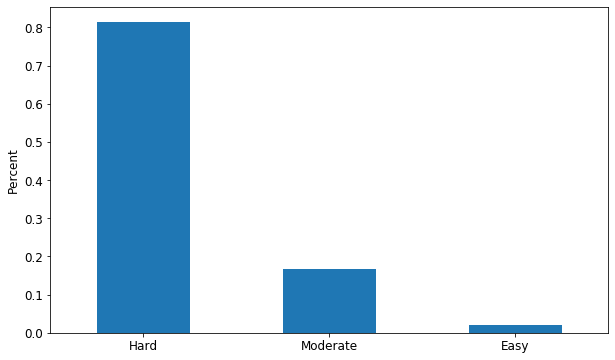

In [99]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts(above_p_99, 'trail_difficulty', bar=True)

Of the trails that are greater than the 99th percentile of `elevation_gain`, 83% are greater than 10,000 feet.

In [100]:
round(above_p_99[['elevation_gain_ft']][above_p_99.elevation_gain_ft > 10000].count().iloc[0] / above_p_99[['elevation_gain_ft']].count().iloc[0], 2)

0.83

Of the trails that are greater than the 99th percentile of `elevation_gain` which are greater than 10,000 feet, 82% are hard.

In [101]:
value_counts(above_p_99[above_p_99.elevation_gain_ft > 10000], 'trail_difficulty', bar=False)

,trail_difficulty,counts,percent
0,Hard,70,0.824
1,Moderate,13,0.153
2,Easy,2,0.024


Since the majority of the trails that are greater than 10,000 feet are hard, the analysis will focus on trails <= 10,000 feet where there exists more variation in `trail_difficulty`.

#### Greater than 95th percentile of `distance_miles`

In [102]:
p_95 = state_trails_df.distance_miles.quantile(0.95)
above_p_95 = state_trails_df[['trail_id', 'trail_difficulty', 'duration_mins', 'elevation_gain_ft', 'distance_miles']][state_trails_df.distance_miles.gt(p_95)].sort_values(by=['distance_miles'], ascending=True)
print(len(above_p_95))
above_p_95

506


,trail_id,trail_difficulty,duration_mins,elevation_gain_ft,distance_miles
8936,10503969,Hard,706.0,4248,22.1
968,10023120,Moderate,nan,4763,22.1
1000,10024025,Moderate,nan,3631,22.1
2172,10035754,Hard,890.0,8763,22.1
6600,10309913,Hard,737.0,5019,22.1
...,...,...,...,...,...
8491,10414459,Hard,"7,249.0",43057,227.8
8490,10414374,Hard,"7,565.0",45246,237.2
4879,10271383,Hard,"9,855.0",68221,293.4
8754,10467025,Moderate,nan,34665,349.1


What is the distribution of `trail_difficulty` for trails with `distance_miles` > 95th percentile?

,trail_difficulty,counts,percent
0,Hard,318,0.628
1,Moderate,151,0.298
2,Easy,37,0.073


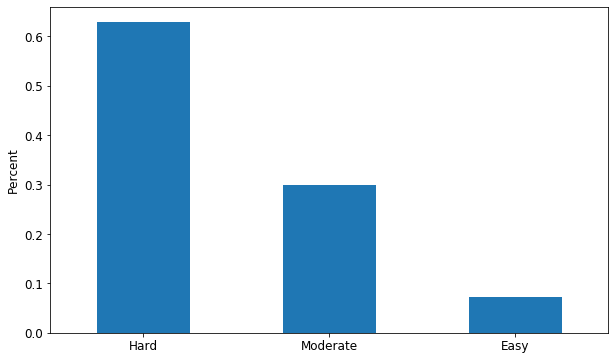

In [103]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts(above_p_95, 'trail_difficulty', bar=True)

#### Greater than 99th percentile of `distance_miles`

In [104]:
p_99 = state_trails_df.distance_miles.quantile(0.99)
above_p_99 = state_trails_df[['trail_id', 'trail_difficulty', 'duration_mins', 'elevation_gain_ft', 'distance_miles']][state_trails_df.distance_miles.gt(p_99)].sort_values(by=['distance_miles'], ascending=True)
print(len(above_p_99))
above_p_99

102


,trail_id,trail_difficulty,duration_mins,elevation_gain_ft,distance_miles
9461,10587702,Moderate,nan,4829,48.5
8704,10456943,Hard,"1,763.0",14452,48.7
8657,10449452,Hard,"1,505.0",8116,48.7
4266,10262809,Hard,"1,696.0",12749,48.8
8420,10407993,Hard,"1,493.0",7391,49.4
...,...,...,...,...,...
8491,10414459,Hard,"7,249.0",43057,227.8
8490,10414374,Hard,"7,565.0",45246,237.2
4879,10271383,Hard,"9,855.0",68221,293.4
8754,10467025,Moderate,nan,34665,349.1


What is the distribution of `trail_difficulty` for trails with `distance_miles` > 99th percentile?

,trail_difficulty,counts,percent
0,Hard,76,0.745
1,Moderate,21,0.206
2,Easy,5,0.049


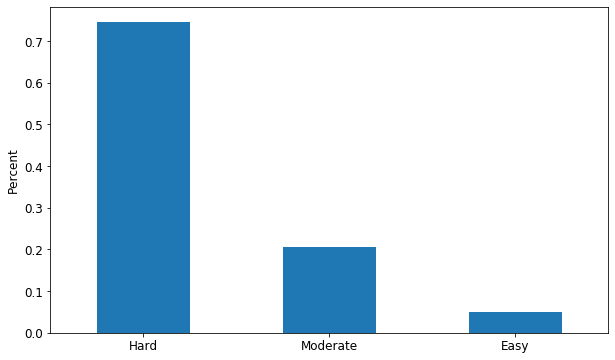

In [105]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts(above_p_99, 'trail_difficulty', bar=True)

Of the trails that are greater than the 99th percentile of `distance_miles`, 94% are greater than 50 miles.

In [106]:
round(above_p_99[['distance_miles']][above_p_99.distance_miles > 50].count().iloc[0] / above_p_99[['distance_miles']].count().iloc[0], 2)

0.94

Of the trails that are greater than the 99th percentile of `distance_miles` which are greater than 50 miles, 74% are hard.

In [107]:
value_counts(above_p_99[above_p_99.distance_miles > 50], 'trail_difficulty', bar=False)

,trail_difficulty,counts,percent
0,Hard,71,0.74
1,Moderate,20,0.208
2,Easy,5,0.052


Since the majority of the trails that are greater than 50 milies are hard, the analysis will focus on trails <= 50 miles where there exists more variation in `trail_difficulty`.

In [108]:
# Creating dataframe where elevation gain <= 10,0000 feet and distance <= 50 miles
state_trails_df_0_10000ft_0_50mi = state_trails_df[(state_trails_df.elevation_gain_ft <= 10000) & (state_trails_df.distance_miles <= 50)]
len(state_trails_df_0_10000ft_0_50mi)

10025

In [109]:
# Describe numeric columns
# Generates descriptive summary statistics of the central tendency, dispersion, and shape of the distribution
# Note: By default only numeric (int64) fields are returned
#       Excludes "NaN" (missing) values
round(state_trails_df_0_10000ft_0_50mi[['trail_id', 'stars', 'num_reviews', 'duration_mins', 'elevation_gain_ft', 'distance_miles']].describe(), 3)

,trail_id,stars,num_reviews,duration_mins,elevation_gain_ft,distance_miles
count,"10,025.0","10,025.0","10,025.0","9,646.0","10,025.0","10,025.0"
mean,"10,263,976.364",4.216,97.25,211.675,"1,323.287",7.032
std,"184,179.952",0.642,206.348,199.022,"1,470.165",6.545
min,"10,000,006.0",0.0,0.0,2.0,0.0,0.1
25%,"10,039,825.0",4.0,12.0,79.0,334.0,2.7
50%,"10,273,357.0",4.5,37.0,150.0,849.0,5.0
75%,"10,350,386.0",4.5,98.0,276.0,"1,745.0",9.1
max,"10,741,577.0",5.0,"5,135.0","1,566.0","9,776.0",49.4


In [110]:
# Describe numeric columns
# Generates descriptive summary statistics of the central tendency, dispersion, and shape of the distribution
# Note: By default only numeric (int64) fields are returned
#       Excludes "NaN" (missing) values
# Remove columns by specifying directly column names
# Note: inplace=True changes the original DataFrame
pd.set_option('max_rows', None, 'max_columns', None)
round(state_trails_df_0_10000ft_0_50mi.drop(columns=['trail_id', 'stars', 'num_reviews', 'duration_mins', 'trail_difficulty_ord', 'elevation_gain_ft', 'distance_miles']).describe(), 3)

,Backpacking,Beach,BikeTouring,BirdWatching,Blowdown,BridgeOut,Bugs,Camping,Cave,CityWalk,Closed,CrossCountrySkiing,DogFriendly,DogsOnLeash,Event,Fee,Fishing,Forest,Hiking,HistoricSite,HorsebackRiding,HotSprings,KidFriendly,Lake,MountainBiking,Muddy,NatureTrips,NoDogs,NoShade,OffTrail,Ohv/OffRoadDriving,OverGrown,PaddleSports,PartiallyPaved,Paved,PrivateProperty,PubWalk,RailsTrails,River,RoadBiking,RockClimbing,Rocky,Running,ScenicDriving,Scramble,Skiing,Snow,Snowshoeing,StrollerFriendly,Views,Walking,WashedOut,Waterfall,WheelchairFriendly,WildFlowers,Wildlife
count,"10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0","10,025.0"
mean,0.128,0.073,0.005,0.503,0.012,0.003,0.06,0.136,0.016,0.018,0.099,0.006,0.155,0.346,0.0,0.031,0.048,0.44,0.905,0.027,0.099,0.005,0.364,0.189,0.208,0.031,0.681,0.251,0.134,0.021,0.033,0.057,0.008,0.05,0.035,0.014,0.0,0.006,0.172,0.043,0.017,0.164,0.533,0.01,0.055,0.003,0.05,0.019,0.037,0.886,0.553,0.024,0.073,0.035,0.579,0.586
std,0.335,0.26,0.071,0.5,0.108,0.056,0.238,0.343,0.125,0.133,0.299,0.076,0.362,0.476,0.022,0.173,0.213,0.496,0.294,0.162,0.299,0.072,0.481,0.391,0.406,0.173,0.466,0.434,0.341,0.143,0.179,0.233,0.091,0.219,0.185,0.119,0.014,0.077,0.377,0.203,0.129,0.37,0.499,0.099,0.228,0.059,0.217,0.137,0.188,0.318,0.497,0.152,0.259,0.184,0.494,0.493
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
75%,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [111]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

In [112]:
# Describe object columns (e.g. categorical, strings, or timestamps)
# Generates descriptive summary statistics of the count, unique values, top values, and frequency
# Note: "top" is the most common value; "freq" is the most common value's frequency
#       Excludes "NaN" (missing) values
round(state_trails_df_0_10000ft_0_50mi.describe(include='object'), 3)

,state,city,trail_name,trail_difficulty,trail_region,route_type
count,10025,10024,10025,10025,10025,10025
unique,1,846,9895,3,1889,3
top,California,Yosemite Valley,Dry Creek Trail,Moderate,Angeles National Forest,Loop
freq,10025,202,4,5087,254,4850


In [113]:
# Calculate the correlation matrix using the default method (Pearson correlation)
state_trails_df_correlations = state_trails_df_0_10000ft_0_50mi[['stars', 'num_reviews', 'duration_mins', 'elevation_gain_ft', 'distance_miles', 'trail_difficulty_ord']].corr(method='pearson')
round(state_trails_df_correlations, 3)

,stars,num_reviews,duration_mins,elevation_gain_ft,distance_miles,trail_difficulty_ord
stars,1.0,0.159,0.054,0.054,0.037,0.096
num_reviews,0.159,1.0,-0.084,-0.065,-0.097,0.017
duration_mins,0.054,-0.084,1.0,0.918,0.987,0.601
elevation_gain_ft,0.054,-0.065,0.918,1.0,0.827,0.655
distance_miles,0.037,-0.097,0.987,0.827,1.0,0.499
trail_difficulty_ord,0.096,0.017,0.601,0.655,0.499,1.0


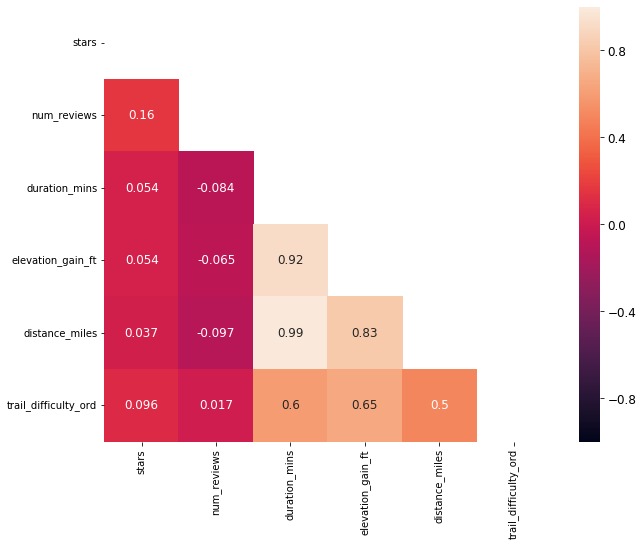

In [114]:
# Create a figure and a set of subplots
# Note: figsize: a tuple (width, height) in inches
fig, ax = plt.subplots(figsize=(10, 8));

# Return an array of zeros with the same shape and type as a given array
mask = np.zeros_like(state_trails_df_correlations, dtype=np.bool)
# Return the indices for the upper-triangle of array
mask[np.triu_indices_from(mask)] = True

# Plot the correlation matrix (color-encoded) using Seaborn's .heatmap() function
# Note: vmin, vmax: values to anchor the colormap, otherwise they are inferred from the data & other keyword arguments
#       annot: write the data value in each cell
ax = sns.heatmap(state_trails_df_correlations, vmin=-1, vmax=1, annot=True, mask=mask, ax=ax);

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10);
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10, va='center', rotation=0);

plt.show();

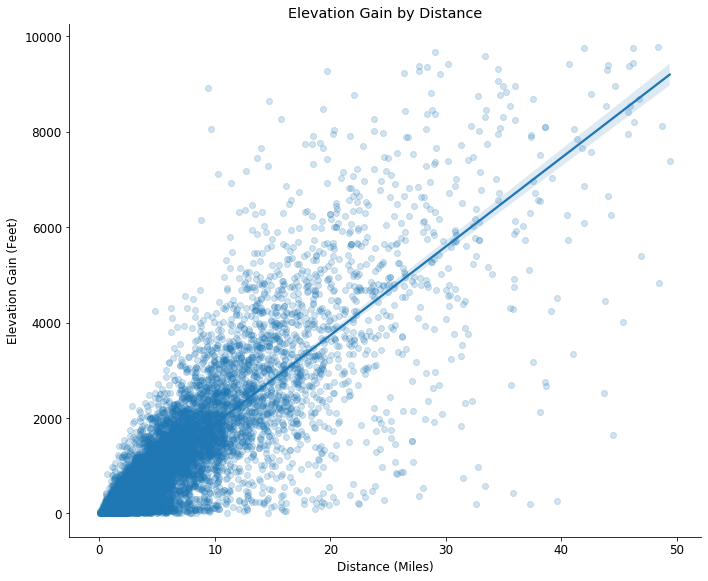

In [115]:
# Plot a simple linear relationship between two variables using Seaborn scatterplot with regression line
# Note: data: DataFrame name
#       height: height (in inches) of each facet
#       aspect: aspect ratio of each facet, so that "aspect * height" gives the width of each facet in inches
#       fit_reg=True estimates and plots a regression model relating the 'x' and 'y' variables
#       ci: size of the confidence interval for the regression estimate
#       truncate: if 'True', the regression line will be bounded by the data limits
#       scatter_kws=alpha: blending value, between 0 (transparent) and 1 (opaque)
sns.lmplot(x='distance_miles', y='elevation_gain_ft', data=state_trails_df_0_10000ft_0_50mi, height=8, aspect=10/8,
           fit_reg=True, ci=95, truncate=True, scatter_kws={'alpha':0.2});
plt.xlabel('Distance (Miles)');
plt.ylabel('Elevation Gain (Feet)');
plt.title('Elevation Gain by Distance');

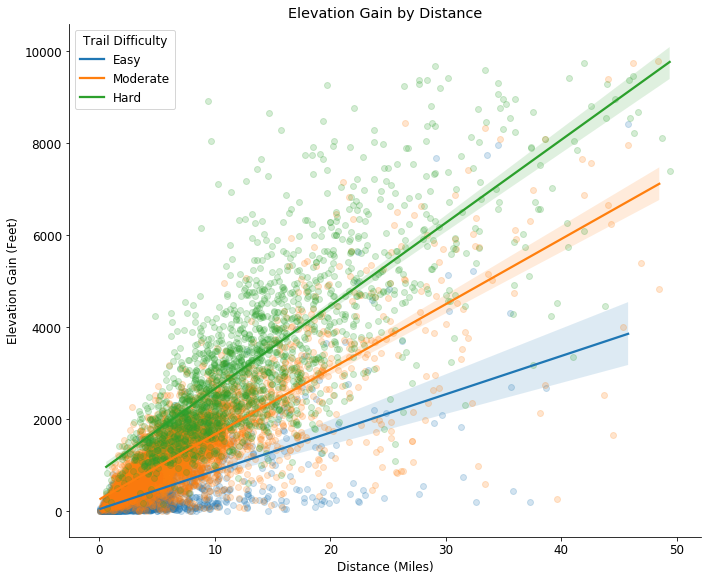

In [116]:
# Note: data: DataFrame name
#       hue: variables that define subsets of the data, which will be drawn on separate facets in the grid
#       height: height (in inches) of each facet
#       aspect: aspect ratio of each facet, so that "aspect * height" gives the width of each facet in inches
#       legend: if 'True' and there is a 'hue' variable, add a legend
#       legend_out: if ''True', the figure size will be extended, and the legend will be drawn outside the plot on the center right
#       fit_reg=True estimates and plots a regression model relating the 'x' and 'y' variables
#       ci: size of the confidence interval for the regression estimate
#       truncate: if 'True', the regression line will be bounded by the data limits
#       scatter_kws=alpha: blending value, between 0 (transparent) and 1 (opaque)
sns.lmplot(x='distance_miles', y='elevation_gain_ft', data=state_trails_df_0_10000ft_0_50mi,
           hue='trail_difficulty_ord', height=8, aspect=10/8, legend=True, legend_out=False,
           fit_reg=True, ci=95, truncate=True, scatter_kws={'alpha':0.2});
plt.xlabel('Distance (Miles)');
plt.ylabel('Elevation Gain (Feet)');
plt.title('Elevation Gain by Distance');
plt.legend(title='Trail Difficulty', labels=['Easy', 'Moderate', 'Hard']);

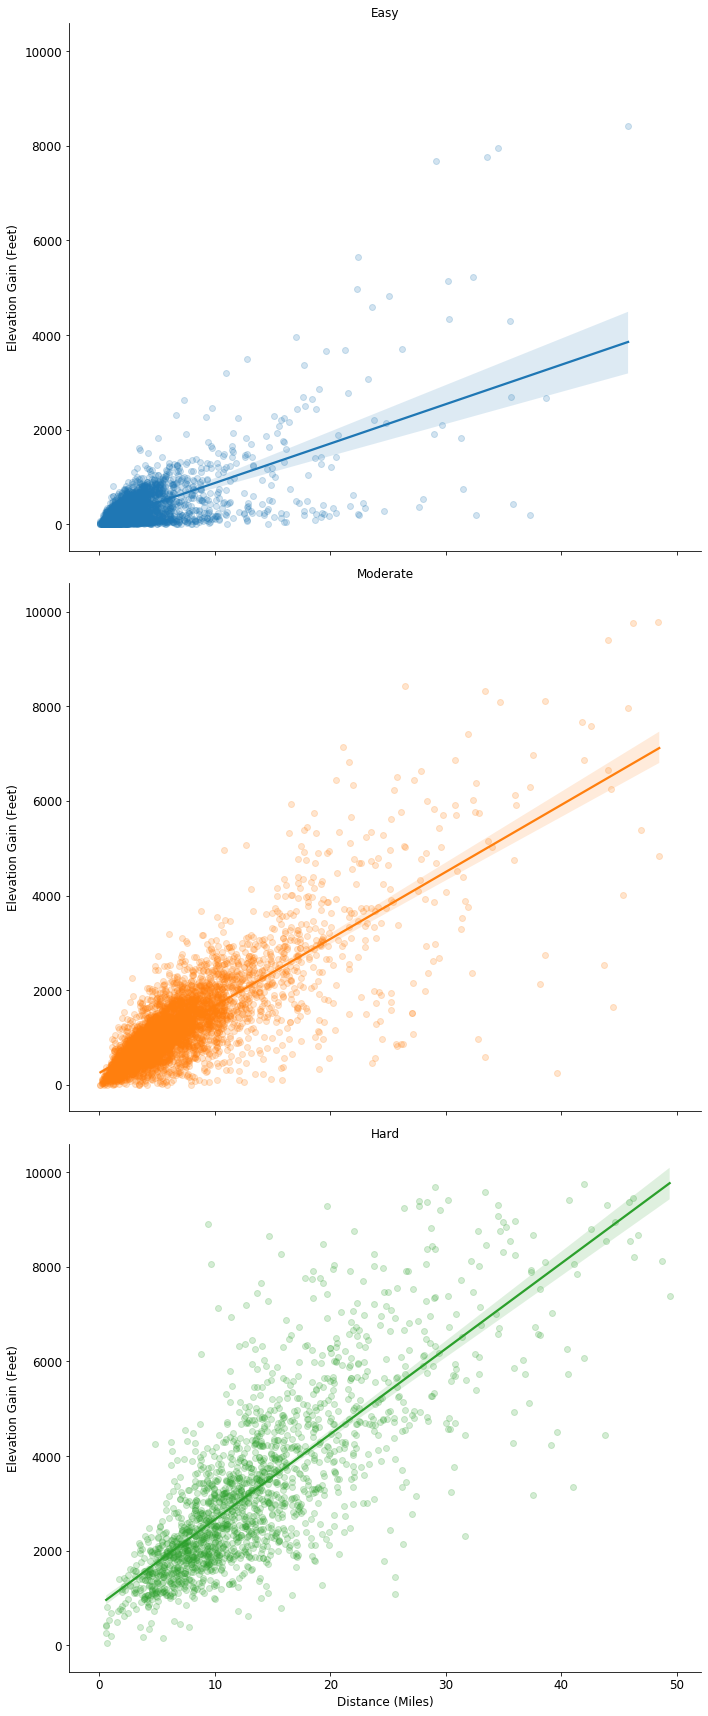

In [117]:
# Note: data: DataFrame name
#       hue: variables that define subsets of the data, which will be drawn on separate facets in the grid
#       row: variables that define subsets of the data, which will be drawn on separate facets in the grid
#       row_order: order for the levels of the faceting variables
#       height: height (in inches) of each facet
#       aspect: aspect ratio of each facet, so that "aspect * height" gives the width of each facet in inches
#       legend: if 'True' and there is a 'hue' variable, add a legend
#       legend_out: if ''True', the figure size will be extended, and the legend will be drawn outside the plot on the center right
#       fit_reg=True estimates and plots a regression model relating the 'x' and 'y' variables
#       ci: size of the confidence interval for the regression estimate
#       truncate: if 'True', the regression line will be bounded by the data limits
#       scatter_kws=alpha: blending value, between 0 (transparent) and 1 (opaque)
fig = sns.lmplot(x='distance_miles', y='elevation_gain_ft', data=state_trails_df_0_10000ft_0_50mi,
                 hue='trail_difficulty_ord', row='trail_difficulty', row_order=['Easy', 'Moderate', 'Hard'],
                 height=8, aspect=10/8, legend=False, legend_out=False,
                 fit_reg=True, ci=95, truncate=True, scatter_kws={'alpha':0.2});
#plt.xlabel('Distance (Miles)');
#plt.ylabel('Elevation Gain (Feet)');
#plt.title('Elevation Gain by Distance');
#plt.legend(title='Trail Difficulty', labels=['Easy', 'Moderate', 'Hard']);
fig.set_axis_labels('Distance (Miles)', 'Elevation Gain (Feet)');
fig.set_titles(row_template='{row_name}');

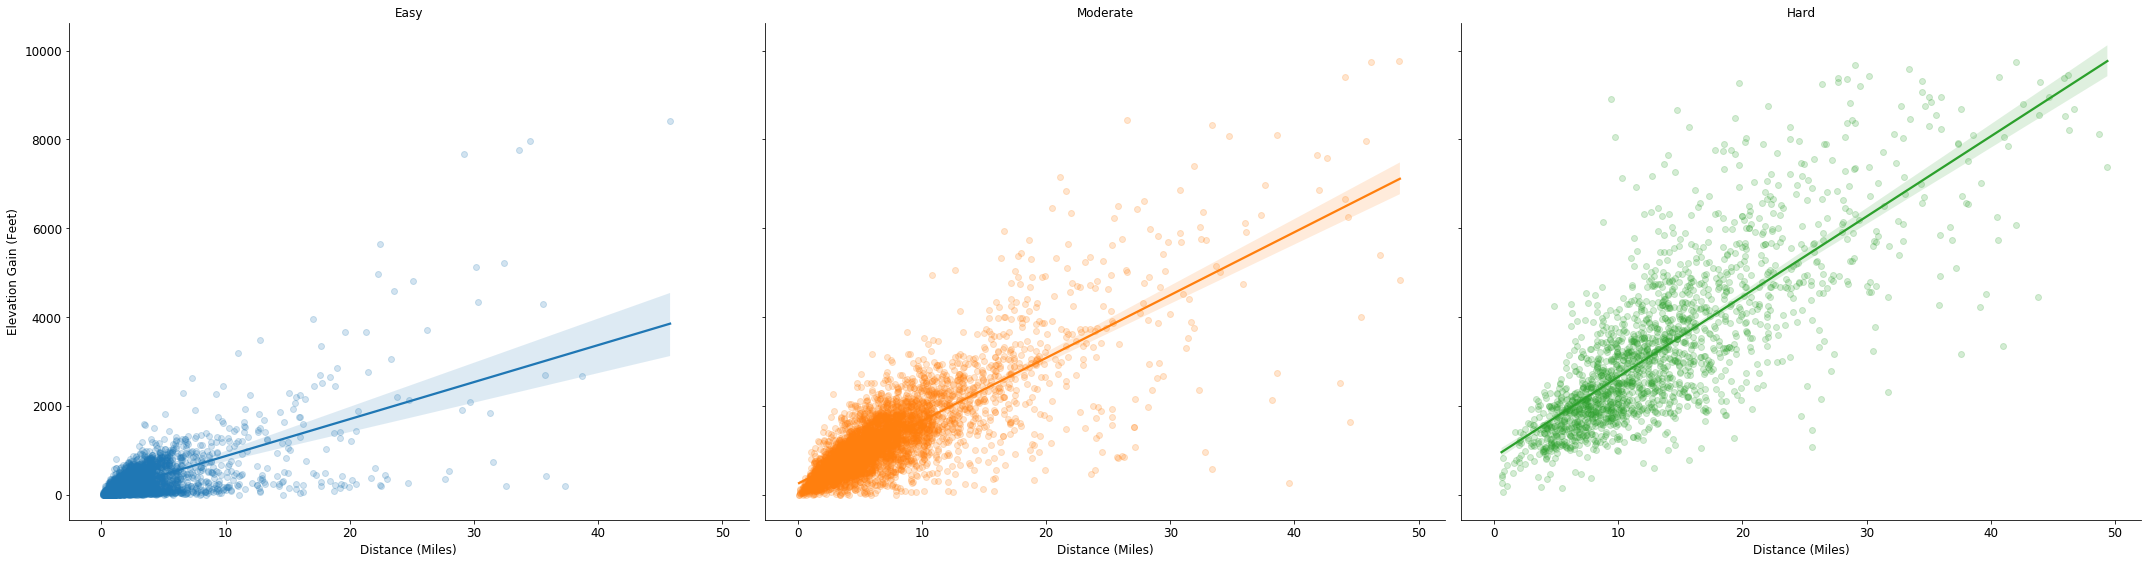

In [118]:
# Note: data: DataFrame name
#       hue: variables that define subsets of the data, which will be drawn on separate facets in the grid
#       col: variables that define subsets of the data, which will be drawn on separate facets in the grid
#       col_order: order for the levels of the faceting variables
#       height: height (in inches) of each facet
#       aspect: aspect ratio of each facet, so that "aspect * height" gives the width of each facet in inches
#       legend: if 'True' and there is a 'hue' variable, add a legend
#       legend_out: if ''True', the figure size will be extended, and the legend will be drawn outside the plot on the center right
#       fit_reg=True estimates and plots a regression model relating the 'x' and 'y' variables
#       ci: size of the confidence interval for the regression estimate
#       truncate: if 'True', the regression line will be bounded by the data limits
#       scatter_kws=alpha: blending value, between 0 (transparent) and 1 (opaque)
fig = sns.lmplot(x='distance_miles', y='elevation_gain_ft', data=state_trails_df_0_10000ft_0_50mi,
                 hue='trail_difficulty_ord', col='trail_difficulty', col_order=['Easy', 'Moderate', 'Hard'],
                 height=8, aspect=10/8, legend=False, legend_out=False,
                 fit_reg=True, ci=95, truncate=True, scatter_kws={'alpha':0.2});
#plt.xlabel('Distance (Miles)');
#plt.ylabel('Elevation Gain (Feet)');
#plt.title('Elevation Gain by Distance');
#plt.legend(title='Trail Difficulty', labels=['Easy', 'Moderate', 'Hard']);
fig.set_axis_labels('Distance (Miles)', 'Elevation Gain (Feet)');
fig.set_titles(col_template='{col_name}');

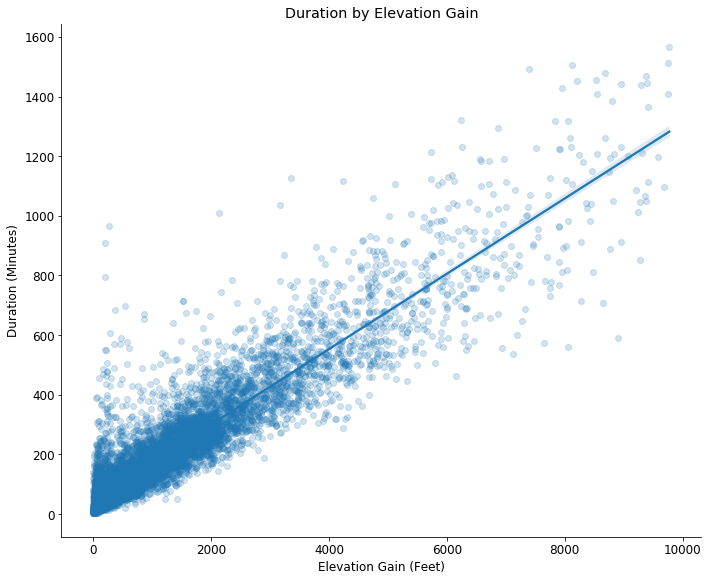

In [119]:
# Plot a simple linear relationship between two variables using Seaborn scatterplot with regression line
# Note: data: DataFrame name
#       height: height (in inches) of each facet
#       aspect: aspect ratio of each facet, so that "aspect * height" gives the width of each facet in inches
#       fit_reg=True estimates and plots a regression model relating the 'x' and 'y' variables
#       ci: size of the confidence interval for the regression estimate
#       truncate: if 'True', the regression line will be bounded by the data limits
#       scatter_kws=alpha: blending value, between 0 (transparent) and 1 (opaque)
sns.lmplot(x='elevation_gain_ft', y='duration_mins', data=state_trails_df_0_10000ft_0_50mi, height=8, aspect=10/8,
           fit_reg=True, ci=95, truncate=True, scatter_kws={'alpha':0.2});
plt.xlabel('Elevation Gain (Feet)');
plt.ylabel('Duration (Minutes)');
plt.title('Duration by Elevation Gain');

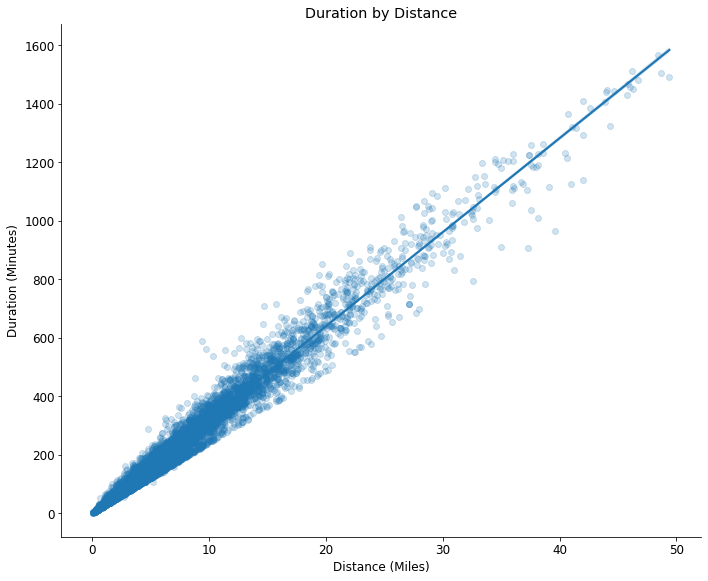

In [120]:
# Plot a simple linear relationship between two variables using Seaborn scatterplot with regression line
# Note: data: DataFrame name
#       height: height (in inches) of each facet
#       aspect: aspect ratio of each facet, so that "aspect * height" gives the width of each facet in inches
#       fit_reg=True estimates and plots a regression model relating the 'x' and 'y' variables
#       ci: size of the confidence interval for the regression estimate
#       truncate: if 'True', the regression line will be bounded by the data limits
#       scatter_kws=alpha: blending value, between 0 (transparent) and 1 (opaque)
sns.lmplot(x='distance_miles', y='duration_mins', data=state_trails_df_0_10000ft_0_50mi, height=8, aspect=10/8,
           fit_reg=True, ci=95, truncate=True, scatter_kws={'alpha':0.2});
plt.xlabel('Distance (Miles)');
plt.ylabel('Duration (Minutes)');
plt.title('Duration by Distance');

#### Chi-Squared Test of Independence

In [121]:
def chi2_test(df, rowvar, colvar):
    # Contingency table
    observed = pd.crosstab(df[rowvar].fillna(' NaN'), df[colvar].fillna(' NaN'), dropna=False)
    print(pd.crosstab(df[rowvar].fillna(' NaN'), df[colvar].fillna(' NaN'), margins=True, margins_name='Total', dropna=False))

    numOfRows = observed.shape[0]
    numOfColumns = observed.shape[1]
    #print(numOfRows)
    #print(numOfColumns)
    
    # Chi-square test of independence of variables in a contingency table
    chi2, p, dof, expected = chi2_contingency(observed)
    print('\nPearson chi2({}) = {}'.format(dof, round(chi2, 3)))
    print('P-value         = {}'.format(round(p, 3)))
    
    alpha = 0.05
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    
    if numOfRows == 2 and numOfColumns == 2:
        # Perform a Fisher exact test on a 2x2 contingency table
        oddsratio, pvalue = stats.fisher_exact(observed)
        print("\nFisher's exact test")
        print('P-value         = {}'.format(round(pvalue, 3)))
        
        if pvalue <= alpha:
            print('Dependent (reject H0)')
        else:
            print('Independent (fail to reject H0)')
    print('\n--------------------------------------\n')
    return p

In [122]:
chi2_pvalue = chi2_test(state_trails_df_0_10000ft_0_50mi, 'route_type', 'trail_difficulty')

trail_difficulty  Easy  Hard  Moderate  Total
route_type                                   
Loop              1597   684      2569   4850
Out & Back        1383   958      2280   4621
Point to Point     122   194       238    554
Total             3102  1836      5087  10025

Pearson chi2(4) = 181.211
P-value         = 0.0
Dependent (reject H0)

--------------------------------------



In [123]:
tag_flags.columns

Index(['Backpacking', 'Beach', 'BikeTouring', 'BirdWatching', 'Blowdown',
       'BridgeOut', 'Bugs', 'Camping', 'Cave', 'CityWalk', 'Closed',
       'CrossCountrySkiing', 'DogFriendly', 'DogsOnLeash', 'Event', 'Fee',
       'Fishing', 'Forest', 'Hiking', 'HistoricSite', 'HorsebackRiding',
       'HotSprings', 'KidFriendly', 'Lake', 'MountainBiking', 'Muddy',
       'NatureTrips', 'NoDogs', 'NoShade', 'OffTrail', 'Ohv/OffRoadDriving',
       'OverGrown', 'PaddleSports', 'PartiallyPaved', 'Paved',
       'PrivateProperty', 'PubWalk', 'RailsTrails', 'River', 'RoadBiking',
       'RockClimbing', 'Rocky', 'Running', 'ScenicDriving', 'Scramble',
       'Skiing', 'Snow', 'Snowshoeing', 'StrollerFriendly', 'Views', 'Walking',
       'WashedOut', 'Waterfall', 'WheelchairFriendly', 'WildFlowers',
       'Wildlife'],
      dtype='object')

In [124]:
# Chi-Squared Test of Independence
# Trail Tags and Trail Difficulty
dependent = []
for i in list(tag_flags.columns):
    chi2_pvalue = chi2_test(state_trails_df_0_10000ft_0_50mi, i, 'trail_difficulty')
    alpha = 0.05
    if chi2_pvalue <= alpha:
        dependent.append(i)

trail_difficulty  Easy  Hard  Moderate  Total
Backpacking                                  
0                 3068  1100      4569   8737
1                   34   736       518   1288
Total             3102  1836      5087  10025

Pearson chi2(2) = 1631.483
P-value         = 0.0
Dependent (reject H0)

--------------------------------------

trail_difficulty  Easy  Hard  Moderate  Total
Beach                                        
0                 2709  1765      4823   9297
1                  393    71       264    728
Total             3102  1836      5087  10025

Pearson chi2(2) = 198.535
P-value         = 0.0
Dependent (reject H0)

--------------------------------------

trail_difficulty  Easy  Hard  Moderate  Total
BikeTouring                                  
0                 3083  1821      5070   9974
1                   19    15        17     51
Total             3102  1836      5087  10025

Pearson chi2(2) = 7.169
P-value         = 0.028
Dependent (reject H0)

-------------

trail_difficulty  Easy  Hard  Moderate  Total
MountainBiking                               
0                 2594  1532      3817   7943
1                  508   304      1270   2082
Total             3102  1836      5087  10025

Pearson chi2(2) = 110.605
P-value         = 0.0
Dependent (reject H0)

--------------------------------------

trail_difficulty  Easy  Hard  Moderate  Total
Muddy                                        
0                 3036  1766      4914   9716
1                   66    70       173    309
Total             3102  1836      5087  10025

Pearson chi2(2) = 14.469
P-value         = 0.001
Dependent (reject H0)

--------------------------------------

trail_difficulty  Easy  Hard  Moderate  Total
NatureTrips                                  
0                 1099   706      1394   3199
1                 2003  1130      3693   6826
Total             3102  1836      5087  10025

Pearson chi2(2) = 101.409
P-value         = 0.0
Dependent (reject H0)

-------------

trail_difficulty  Easy  Hard  Moderate  Total
Waterfall                                    
0                 2972  1597      4729   9298
1                  130   239       358    727
Total             3102  1836      5087  10025

Pearson chi2(2) = 134.301
P-value         = 0.0
Dependent (reject H0)

--------------------------------------

trail_difficulty    Easy  Hard  Moderate  Total
WheelchairFriendly                             
0                   2771  1836      5066   9673
1                    331     0        21    352
Total               3102  1836      5087  10025

Pearson chi2(2) = 680.257
P-value         = 0.0
Dependent (reject H0)

--------------------------------------

trail_difficulty  Easy  Hard  Moderate  Total
WildFlowers                                  
0                 1598   664      1961   4223
1                 1504  1172      3126   5802
Total             3102  1836      5087  10025

Pearson chi2(2) = 165.615
P-value         = 0.0
Dependent (reject H0)

----

In [125]:
len(dependent)

50

In [126]:
dependent

['Backpacking',
 'Beach',
 'BikeTouring',
 'BirdWatching',
 'Blowdown',
 'BridgeOut',
 'Bugs',
 'Camping',
 'CityWalk',
 'Closed',
 'DogFriendly',
 'DogsOnLeash',
 'Fishing',
 'Forest',
 'Hiking',
 'HistoricSite',
 'HorsebackRiding',
 'HotSprings',
 'KidFriendly',
 'Lake',
 'MountainBiking',
 'Muddy',
 'NatureTrips',
 'NoDogs',
 'NoShade',
 'OffTrail',
 'Ohv/OffRoadDriving',
 'OverGrown',
 'PaddleSports',
 'PartiallyPaved',
 'Paved',
 'RailsTrails',
 'River',
 'RoadBiking',
 'RockClimbing',
 'Rocky',
 'Running',
 'ScenicDriving',
 'Scramble',
 'Skiing',
 'Snow',
 'Snowshoeing',
 'StrollerFriendly',
 'Views',
 'Walking',
 'WashedOut',
 'Waterfall',
 'WheelchairFriendly',
 'WildFlowers',
 'Wildlife']

## Distributions

#### Elevation Gain

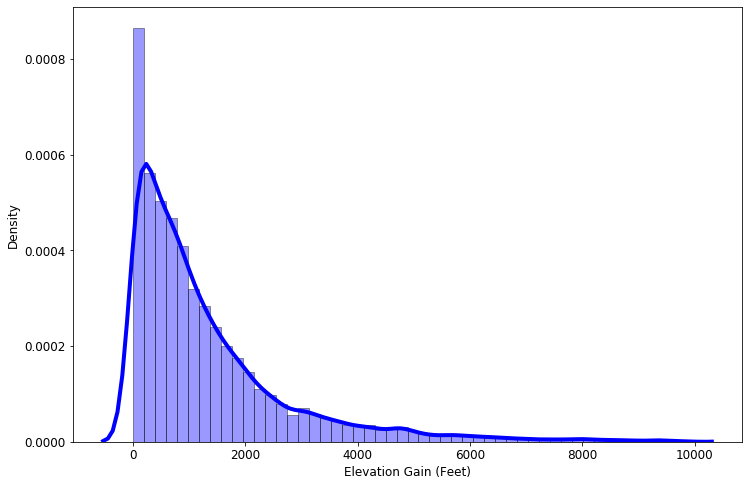

In [127]:
sns.distplot(state_trails_df_0_10000ft_0_50mi['elevation_gain_ft'], hist=True, kde=True, 
             color='blue', 
             hist_kws={'edgecolor': 'black'},
             kde_kws={'linewidth': 4});
plt.xlabel('Elevation Gain (Feet)');
plt.ylabel('Density');

In [128]:
# For each trail_difficulty group, describe elevation_gain_ft:
round(state_trails_df_0_10000ft_0_50mi.groupby(by='trail_difficulty').elevation_gain_ft.describe(), 3)

,count,mean,std,min,25%,50%,75%,max
trail_difficulty,,,,,,,,
Easy,"3,102.0",336.655,526.515,0.0,72.0,203.0,428.25,"8,421.0"
Hard,"1,836.0","3,284.44","1,803.575",59.0,"1,951.0","2,888.5","4,210.5","9,750.0"
Moderate,"5,087.0","1,217.105",961.158,0.0,623.0,987.0,"1,528.0","9,776.0"


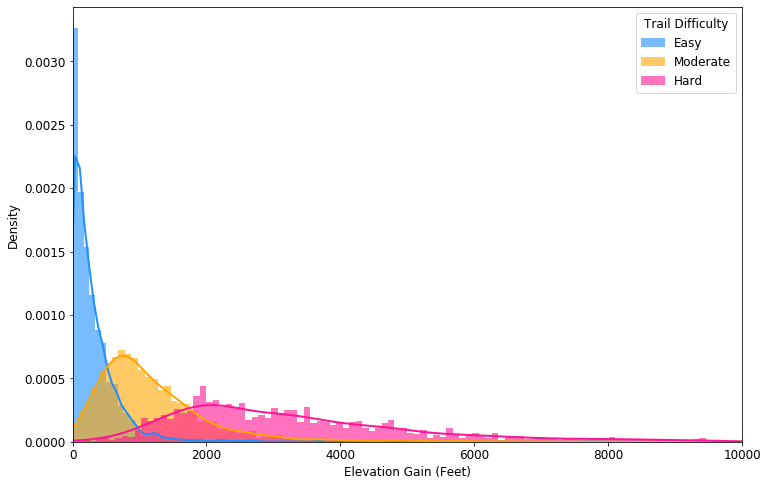

In [129]:
x1 = state_trails_df_0_10000ft_0_50mi.loc[state_trails_df_0_10000ft_0_50mi.trail_difficulty=='Easy', 'elevation_gain_ft']
x2 = state_trails_df_0_10000ft_0_50mi.loc[state_trails_df_0_10000ft_0_50mi.trail_difficulty=='Moderate', 'elevation_gain_ft']
x3 = state_trails_df_0_10000ft_0_50mi.loc[state_trails_df_0_10000ft_0_50mi.trail_difficulty=='Hard', 'elevation_gain_ft']

# Plot
kwargs = dict(hist_kws={'alpha': .6}, kde_kws={'linewidth': 2})

sns.distplot(x1, color='dodgerblue', label='Easy', **kwargs, bins=int(10000/100)) # Bins represent 100 feet
sns.distplot(x2, color='orange', label='Moderate', **kwargs, bins=int(10000/100))
sns.distplot(x3, color='deeppink', label='Hard', **kwargs, bins=int(10000/100))
plt.xlim(0, 10000)
plt.xlabel('Elevation Gain (Feet)')
plt.ylabel('Density')
plt.legend(title='Trail Difficulty');

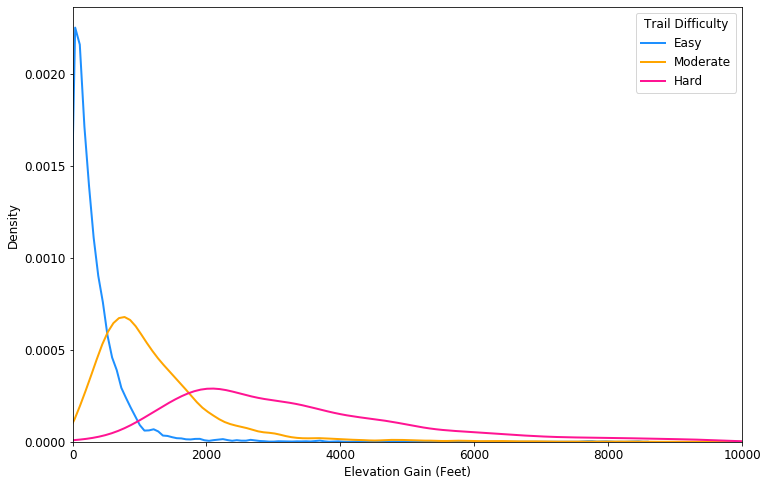

In [130]:
x1 = state_trails_df_0_10000ft_0_50mi.loc[state_trails_df_0_10000ft_0_50mi.trail_difficulty=='Easy', 'elevation_gain_ft']
x2 = state_trails_df_0_10000ft_0_50mi.loc[state_trails_df_0_10000ft_0_50mi.trail_difficulty=='Moderate', 'elevation_gain_ft']
x3 = state_trails_df_0_10000ft_0_50mi.loc[state_trails_df_0_10000ft_0_50mi.trail_difficulty=='Hard', 'elevation_gain_ft']

# Plot
kwargs = dict(hist_kws={'alpha': .6}, kde_kws={'linewidth': 2})

sns.distplot(x1, hist=False, color='dodgerblue', label='Easy', **kwargs)
sns.distplot(x2, hist=False, color='orange', label='Moderate', **kwargs)
sns.distplot(x3, hist=False, color='deeppink', label='Hard', **kwargs)
plt.xlim(0, 10000)
plt.xlabel('Elevation Gain (Feet)')
plt.ylabel('Density')
plt.legend(title='Trail Difficulty');

#### Distance

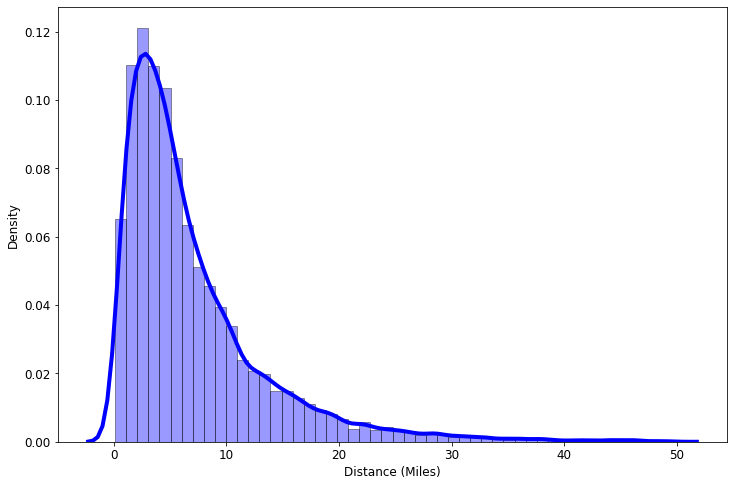

In [131]:
sns.distplot(state_trails_df_0_10000ft_0_50mi['distance_miles'], hist=True, kde=True, 
             color='blue', 
             hist_kws={'edgecolor': 'black'},
             kde_kws={'linewidth': 4});
plt.xlabel('Distance (Miles)');
plt.ylabel('Density');

In [132]:
# For each trail_difficulty group, describe distance_miles:
round(state_trails_df_0_10000ft_0_50mi.groupby(by='trail_difficulty').distance_miles.describe(), 3)

,count,mean,std,min,25%,50%,75%,max
trail_difficulty,,,,,,,,
Easy,"3,102.0",3.557,4.135,0.1,1.3,2.4,4.1,45.8
Hard,"1,836.0",13.478,7.76,0.6,8.1,11.8,16.7,49.4
Moderate,"5,087.0",6.825,5.464,0.1,3.5,5.4,8.3,48.5


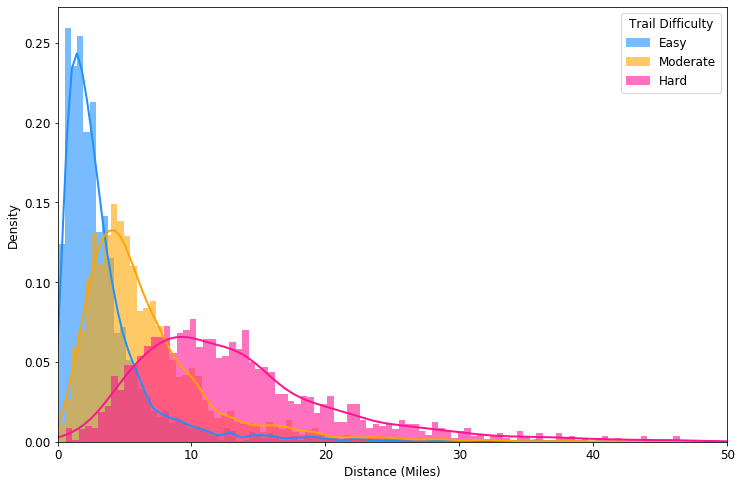

In [133]:
x1 = state_trails_df_0_10000ft_0_50mi.loc[state_trails_df_0_10000ft_0_50mi.trail_difficulty=='Easy', 'distance_miles']
x2 = state_trails_df_0_10000ft_0_50mi.loc[state_trails_df_0_10000ft_0_50mi.trail_difficulty=='Moderate', 'distance_miles']
x3 = state_trails_df_0_10000ft_0_50mi.loc[state_trails_df_0_10000ft_0_50mi.trail_difficulty=='Hard', 'distance_miles']

# Plot
kwargs = dict(hist_kws={'alpha': .6}, kde_kws={'linewidth': 2})

sns.distplot(x1, color='dodgerblue', label='Easy', **kwargs, bins=int(50/.5)) # Bins represent 0.5 miles
sns.distplot(x2, color='orange', label='Moderate', **kwargs, bins=int(50/.5))
sns.distplot(x3, color='deeppink', label='Hard', **kwargs, bins=int(50/.5))
plt.xlim(0, 50)
plt.xlabel('Distance (Miles)')
plt.ylabel('Density')
plt.legend(title='Trail Difficulty');

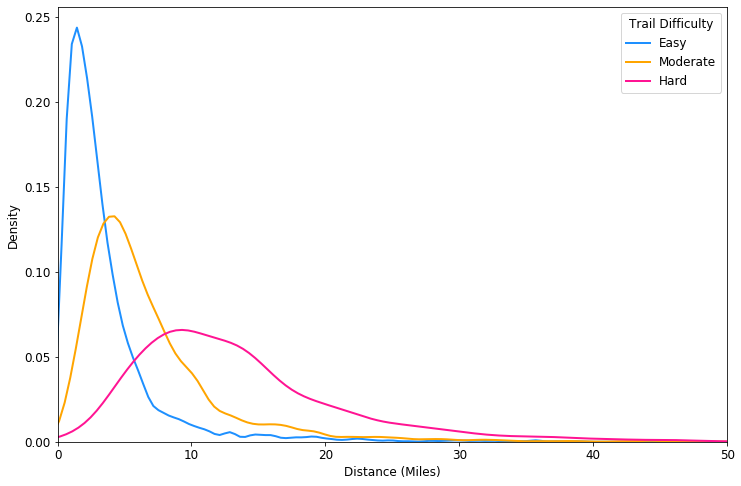

In [134]:
x1 = state_trails_df_0_10000ft_0_50mi.loc[state_trails_df_0_10000ft_0_50mi.trail_difficulty=='Easy', 'distance_miles']
x2 = state_trails_df_0_10000ft_0_50mi.loc[state_trails_df_0_10000ft_0_50mi.trail_difficulty=='Moderate', 'distance_miles']
x3 = state_trails_df_0_10000ft_0_50mi.loc[state_trails_df_0_10000ft_0_50mi.trail_difficulty=='Hard', 'distance_miles']

# Plot
kwargs = dict(hist_kws={'alpha': .6}, kde_kws={'linewidth': 2})

sns.distplot(x1, hist=False, color='dodgerblue', label='Easy', **kwargs)
sns.distplot(x2, hist=False, color='orange', label='Moderate', **kwargs)
sns.distplot(x3, hist=False, color='deeppink', label='Hard', **kwargs)
plt.xlim(0, 50)
plt.xlabel('Distance (Miles)')
plt.ylabel('Density')
plt.legend(title='Trail Difficulty');